seems like kmeans is working better than DBSCAN however this is more of just direct on sentiment 

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import umap.umap_ as umap
from sklearn.metrics import silhouette_score

In [116]:
gold_df = pd.read_csv("gold-dataset-sinha-khandait.csv")

In [117]:
headlines_data = np.array(gold_df["News"])

In [118]:
headlines_data

array(['april gold down 20 cents to settle at $1,116.10/oz',
       'gold suffers third straight daily decline',
       'Gold futures edge up after two-session decline', ...,
       'Gold heading for worst week since November on rate hike worries',
       'august gold up $7.60 at $878.80 an ounce on nymex',
       'december gold down $1 at $749 an ounce on nymex'], dtype=object)

In [119]:
headlines_data.shape

(10570,)

In [120]:
def preprocess(texts):
    import re

    return [re.sub(r"[^\w\s]", "", t.lower()).strip() for t in texts]


headlines_data = preprocess(headlines_data)

In [121]:
model = SentenceTransformer("all-mpnet-base-v2")
X = model.encode(headlines_data)

In [122]:
print(X)

[[-0.03504395 -0.00360659 -0.00691248 ... -0.00363126 -0.02674786
   0.01424351]
 [ 0.0186689   0.03730345 -0.0280543  ...  0.00101579 -0.06898952
   0.01544286]
 [-0.0549108   0.06175185 -0.00415515 ... -0.01126827  0.01854271
   0.01297552]
 ...
 [-0.0288155   0.02776974 -0.0083451  ... -0.00855119 -0.04872278
   0.01761814]
 [-0.03872148 -0.00690373 -0.00266231 ... -0.01713954 -0.01068293
   0.03211237]
 [-0.06162114  0.02536986 -0.00934584 ... -0.04300914 -0.00095558
   0.02882916]]


In [123]:
X.shape

(10570, 768)

In [124]:
# reduce dimensions from 768 to 25
reducer = umap.UMAP(n_components=25, random_state=42)
X_umap = reducer.fit_transform(X)

/Users/visheshgupta/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/visheshgupta/miniforge3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [125]:
X_umap.shape

(10570, 25)

In [126]:
# track score
silhouette_scores = []
inertias = []
K = range(2, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_umap)
    inertia = kmeans.inertia_
    score = silhouette_score(X_umap, labels)

    inertias.append(inertia)
    silhouette_scores.append(score)

<function matplotlib.pyplot.show(close=None, block=None)>

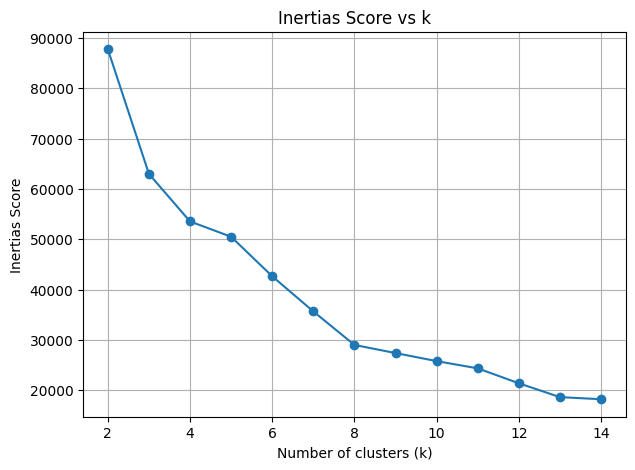

In [127]:
plt.figure(figsize=(7, 5))
plt.plot(K, inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertias Score")
plt.title("Inertias Score vs k")
plt.grid(True)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

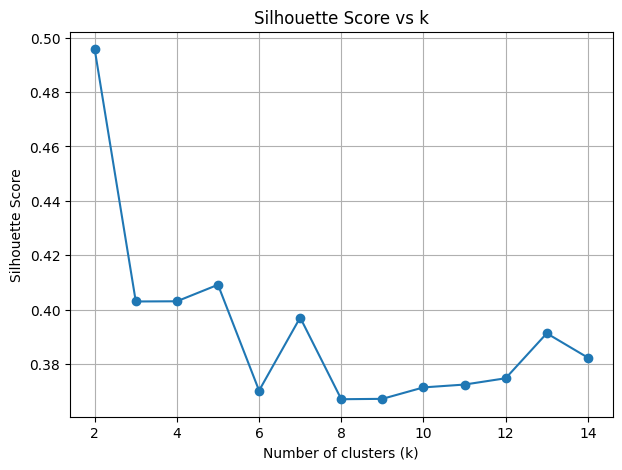

In [128]:
plt.figure(figsize=(7, 5))
plt.plot(K, silhouette_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs k")
plt.grid(True)
plt.show

In [129]:
silhouette_scores

[0.49571657,
 0.40301442,
 0.403083,
 0.40915936,
 0.37026122,
 0.39710966,
 0.3670942,
 0.367231,
 0.37143895,
 0.37248385,
 0.3747998,
 0.3913121,
 0.38237005]

In [130]:
best_k = K[np.argmax(silhouette_scores)]
print(f"Best k based on silhouette score: {best_k}")

Best k based on silhouette score: 2


In [131]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_umap)

In [132]:
X_2d = umap.UMAP(n_components=2, random_state=42).fit_transform(X_umap)

/Users/visheshgupta/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/visheshgupta/miniforge3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [134]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_umap)

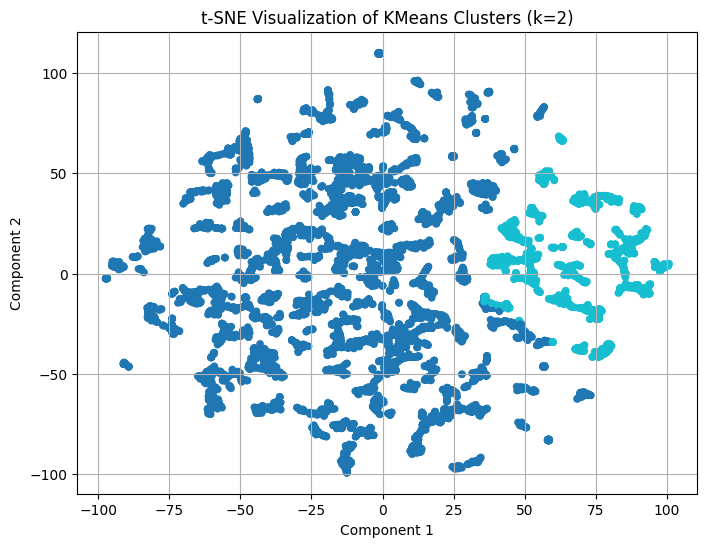

In [136]:
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap="tab10", s=20)
plt.title(f"t-SNE Visualization of KMeans Clusters (k={best_k})")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

In [137]:
from collections import defaultdict

clustered_headlines = defaultdict(list)

for headline, label in zip(headlines_data, kmeans_labels):
    clustered_headlines[label].append(headline)

In [138]:
clustered_headlines

defaultdict(list,
            {1: ['april gold down 20 cents to settle at 111610oz',
              'dec gold climbs 940 or 07 to settle at 135690oz',
              'april gold holds slight gain up 250 or 02 at 132020oz',
              'feb gold ends up 960 or 11 at 90160 an ounce',
              'april gold up 140 to end the day at 55440oz in ny',
              'august gold ends up 160 or 02 at 93620',
              'feb gold falls 10c to 45220oz in morning ny trade',
              'feb gold down 120 to close at 159670oz',
              'philly gold and silver index falls 05 to end at 9353',
              'dec gold settles at 126990oz up 7 or 06',
              'december gold trades 08 higher at 1289oz',
              'gold ends 05 higher at 115960 an ounce',
              'august gold rises 02 at 125750oz',
              'december gold gains 410 or 03 to 134530oz',
              'dec gold down 30 cents at 1310oz on globex',
              'dec gold settles at 132370oz down 190 or 01',


In [139]:
for cluster_id, headlines in clustered_headlines.items():
    print(f"\n Cluster {cluster_id} — showing 10 headlines:")
    print("-" * 50)
    for h in headlines[:10]:
        print(f"• {h}")


 Cluster 1 — showing 10 headlines:
--------------------------------------------------
• april gold down 20 cents to settle at 111610oz
• dec gold climbs 940 or 07 to settle at 135690oz
• april gold holds slight gain up 250 or 02 at 132020oz
• feb gold ends up 960 or 11 at 90160 an ounce
• april gold up 140 to end the day at 55440oz in ny
• august gold ends up 160 or 02 at 93620
• feb gold falls 10c to 45220oz in morning ny trade
• feb gold down 120 to close at 159670oz
• philly gold and silver index falls 05 to end at 9353
• dec gold settles at 126990oz up 7 or 06

 Cluster 0 — showing 10 headlines:
--------------------------------------------------
• gold suffers third straight daily decline
• gold futures edge up after twosession decline
• dent research  is golds day in the sun coming soon
• gold snaps threeday rally as trump lawmakers reach debtceiling deal
• gold falls by rs 25 on sluggish demand global cues
• gold futures fall for the session but gain for the week
• gold struggle

In [140]:
eps_values = [0.3, 0.5, 0.7, 1.0]
min_samples_values = [3, 5]
metrics = ["euclidean", "cosine"]

In [141]:
best_score = -1
best_eps = None
best_min_samples = None
best_metric = None
best_labels = None

# Test all combinations
for eps in eps_values:
    for min_samples in min_samples_values:
        for metric in metrics:
            print(f"Testing: eps={eps}, min_samples={min_samples}, metric={metric}")

            # Run DBSCAN
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
            db_labels = dbscan.fit_predict(X_umap)

            # Calculate Silhouette Score (only if more than 1 cluster)
            n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
            if n_clusters > 1:
                score = silhouette_score(X_umap, db_labels)
                print(f"Silhouette Score: {score:.4f} — Found {n_clusters} clusters.")

                # Update best score
                if score > best_score:
                    best_score = score
                    best_eps = eps
                    best_min_samples = min_samples
                    best_metric = metric
                    best_labels = db_labels
            else:
                print(f"Only 1 cluster found (Silhouette score not applicable).")

Testing: eps=0.3, min_samples=3, metric=euclidean
Silhouette Score: -0.4056 — Found 88 clusters.
Testing: eps=0.3, min_samples=3, metric=cosine
Only 1 cluster found (Silhouette score not applicable).
Testing: eps=0.3, min_samples=5, metric=euclidean
Silhouette Score: -0.3284 — Found 64 clusters.
Testing: eps=0.3, min_samples=5, metric=cosine
Only 1 cluster found (Silhouette score not applicable).
Testing: eps=0.5, min_samples=3, metric=euclidean
Silhouette Score: -0.2198 — Found 21 clusters.
Testing: eps=0.5, min_samples=3, metric=cosine
Only 1 cluster found (Silhouette score not applicable).
Testing: eps=0.5, min_samples=5, metric=euclidean
Silhouette Score: -0.0664 — Found 17 clusters.
Testing: eps=0.5, min_samples=5, metric=cosine
Only 1 cluster found (Silhouette score not applicable).
Testing: eps=0.7, min_samples=3, metric=euclidean
Silhouette Score: -0.2494 — Found 13 clusters.
Testing: eps=0.7, min_samples=3, metric=cosine
Only 1 cluster found (Silhouette score not applicable).


In [142]:
best_score

-0.066413574